In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from hyppo.discrim import DiscrimOneSample

Run experiment in 259.1 seconds
DISCR mean = 0.7248611111111112, std:0.04794926427427688
p values mean = 0.006940000000000001, std:0.013031362169781026


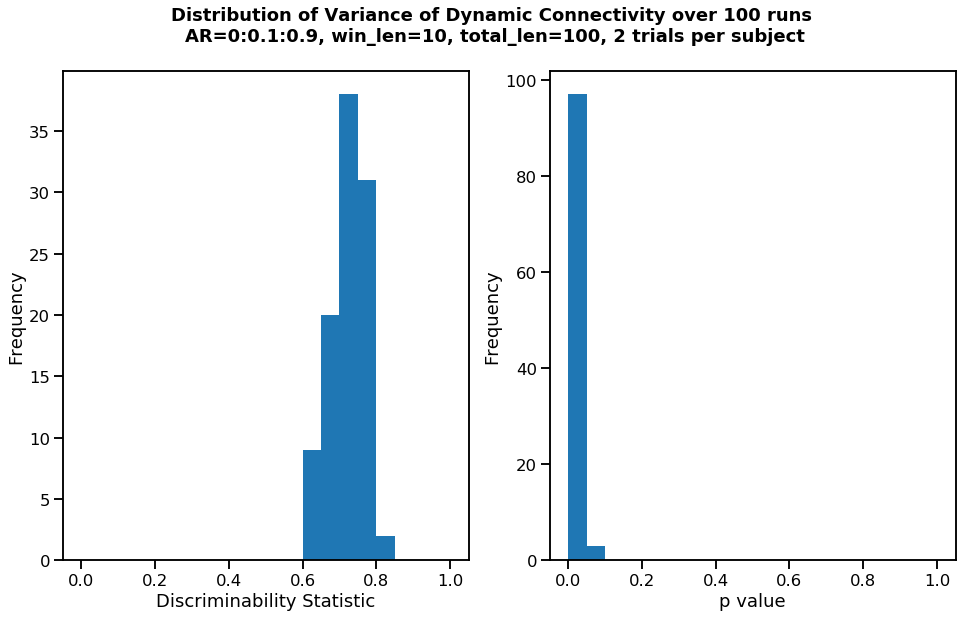

In [2]:
def sample_data(subjects=10, trials=2, nodes=10, win_length=10, total_length=100,
                step_size=10, seed=None, measure='var'):
    if seed is not None:
        np.random.seed(seed)

    measurements = []
    times = list(np.arange(0, total_length - win_length + 1, step_size))
    time_steps = len(times)
    for j in range(subjects):
        # phi = 0.5
        phi = 0.1*j  # A=0:0.1:0.9
        # phi = 0.2*j - 0.9  # A=-0.9:0.2:0.9
        A = np.ones(10)*phi  # MAR(1) coefficient matrix
        for s in range(trials):
            # Simulate time series for each trial
            X = np.zeros((nodes, total_length))
            X[:,0] = np.random.normal(size=nodes, scale=np.sqrt(1 - phi*phi))
            for i in range(np.size(X, 1) - 1):
                epsilon = np.random.normal(size=nodes, scale=np.sqrt(1 - phi*phi))
                X[:, i + 1] = A * X[:, i] + epsilon

            # Calculate correlation matrix with sliding window mwthod
            features = []

            for i, t in enumerate(times):
                corr_matrix = np.corrcoef(X[:, t:t + step_size])
                features.append(corr_matrix[np.triu_indices(nodes, 1)].flatten())
            if measure == 'mean':
                measurements.append(np.mean(np.asarray(features), axis=0))
            elif measure == 'var':
                measurements.append(np.var(np.asarray(features), axis=0))

    measurements = np.asarray(measurements)
    # subjects*trials measurements in total
    labels = np.repeat(np.arange(1, subjects + 1), trials)

    return measurements, labels


def run_exp(seed=None):
    x, y = sample_data(seed=seed, win_length=10, total_length=100, step_size=10, trials=2, measure='var')
    stats, p = DiscrimOneSample().test(x, y)

    return stats, p


def main():
    par = Parallel(n_jobs=8, verbose=0)
    np.random.seed(8888)
    n_sims = 100
    seeds = np.random.randint(1e8, size=n_sims)

    tic = time.perf_counter()
    res = par(delayed(run_exp)(seed) for seed in seeds)
    toc = time.perf_counter()
    print(f"Run experiment in {toc - tic:.1f} seconds")
    p_values = np.asarray(res)[:, 1]
    discr_stats = np.asarray(res)[:, 0]
    print(f"DISCR mean = {np.mean(discr_stats)}, std:{np.std(discr_stats)}")
    print(f"p values mean = {np.mean(p_values)}, std:{np.std(p_values)}")

    with sns.plotting_context('talk'):
        fig, axes = plt.subplots(1, 2, figsize=(16, 9))
        fig.suptitle(f'Distribution of Variance of Dynamic Connectivity over {n_sims} runs \n'
                     f'AR=0:0.1:0.9, win_len=10, total_len=100, 2 trials per subject',
                     fontsize=18, fontweight='bold')

        axes[0].hist(discr_stats, np.arange(0, 1.05, 0.05))
        axes[0].set_xlabel("Discriminability Statistic")
        axes[0].set_ylabel("Frequency")

        axes[1].hist(p_values, np.arange(0, 1.05, 0.05))
        axes[1].set_xlabel("p value")
        axes[1].set_ylabel("Frequency")


if __name__ == "__main__":
    main()